# Knowledge discovery from COVID-19 data

## Contents
1. Purpose of the project
2. Data collection
3. Data preprocessing
4. Data mining
5. Evaluation
6. Next steps

## 1. Purpose of the project

As we all know, there are differences in measures taken by countries to fight the COVID-19 epidemic. Some countries implement a full lockdown on society, whereas some try to keep everyday life almost normal. The aim of this project was to examine these differences, find out which countries have chosen alternative ways, and figure out patterns between actions and registered cases.

## 2. Data collection

I used three datasets:
1. $\text{COVID-19 containment and mitigation measures}^1$.
2. $\text{Time series on confirmed cases globally}^2$.
3. $\text{Population by country in 2020}^3$.

[1] https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures

[2] https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

[3] https://www.kaggle.com/tanuprabhu/population-by-country-2020

## 3. Data preprocessing

I decided to divide my work on project into two parts:
1. Within **four selected countries**, examining common patterns between measurements and cases.
2. Within **all countries**, examining trends in measurements, trying out classification and anomaly detection.

**Part 1**
1. Chose Finland, Iceland, Italy, and South Korea for examination.
2. Calculated the growths in registered cases for 10-day intervals.
3. Used logarithmic standardization to even the differences in growths.
4. Denoted the level of growths with terms "High increase", "Medium increase", "Low increase".
5. For each measurement taken, found out which growth level was registered 10 days after the implementation.

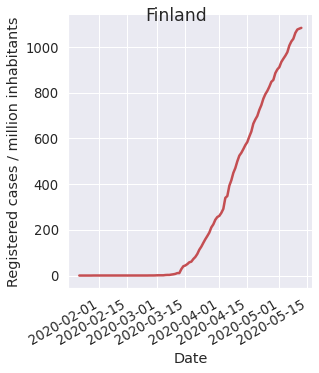

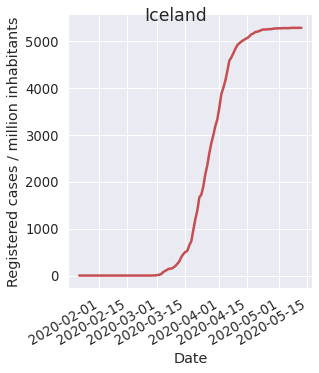

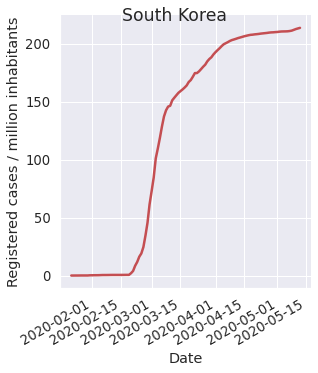

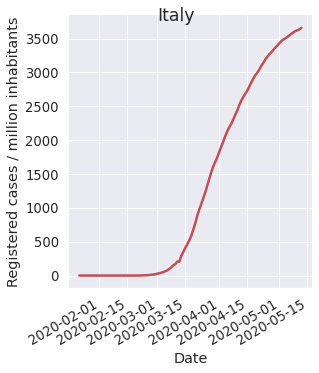

In [28]:
# -*- coding: utf-8 -*-
"""
Visualizing COVID-19 registered cases time series.

Created on Thu May 14 17:07:20 2020

@author: bonskotti
"""

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def visualize_cases(cases, p):
    """
    Visualizing registered cases.

    Parameters
    ----------
    cases : dataframe
        country specific case data.
    p : int
        country population

    Returns
    -------
    sns.replot

    """
    
    # plotting   
    dates = list(pd.to_datetime(cases.columns.values[4:]))
    numbers = list(cases.iloc[0].values[4:])
    numbers/=(p/1000000) # per 100,000 inhabitants
    df = pd.DataFrame({"Date": dates,\
                       "Registered cases / million inhabitants": numbers})
        
    sns.set(style='darkgrid')
    sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
    return sns.relplot(x='Date', y='Registered cases / million inhabitants',kind="line",\
                       color='r',data=df)
 
       
# import data
cases = pd.read_csv('../data/time_series_covid19_confirmed_global.csv')
measurements = pd.read_csv('../data/COVID 19 Containment measures data.csv')
population = pd.read_csv('../data/population_by_country_2020.csv')

# most common measures
common = measurements['Keywords'].value_counts()[:10]

# seperate countries
m_country_specific = {country:measurements[measurements['Country']==country] for country in\
                    measurements['Country'].unique()} 
c_country_specific = {country:cases[cases['Country/Region']==country] for country in\
                    cases['Country/Region'].unique()}
    
# get finnish, icelandic, south-korean, italian data  
c_fin = c_country_specific['Finland'].copy()
m_fin = m_country_specific['Finland'].copy()
c_ice = c_country_specific['Iceland'].copy()
m_ice = m_country_specific['Iceland'].copy()
m_ice.dropna(axis=0,subset=['Keywords'],inplace=True)
c_sk = c_country_specific['Korea, South'].copy()
m_sk = m_country_specific['South Korea'].copy()
m_sk.dropna(axis=0,subset=['Keywords'],inplace=True)
c_it = c_country_specific['Italy'].copy()
m_it = m_country_specific['Italy'].copy()
m_it.dropna(axis=0,subset=['Keywords'],inplace=True)

# visualize growth of registered cases
countries = ['Finland',
             'Iceland',
             'South Korea',
             'Italy']
p = [population.loc[population['Country (or dependency)'] == x]['Population (2020)'].values[0]
     for x in countries]
c = [c_fin,c_ice,c_sk,c_it]


for i,j in enumerate(c):
    f = visualize_cases(c[i],p[i])
    f.fig.autofmt_xdate()
    f.fig.suptitle(countries[i])

sns.reset_orig()




**Part 2**
1. Examined the most common measures taken in all countries. 
2. Created a dataframe with 10 most common measures, and information on whether a country had implemented it or not.
3. Ran principal component analysis on data.

## 4. Data mining

### Part 1: Association rule mining

Ran the apriori-algorithm for each of the four countries. 

In [29]:
# -*- coding: utf-8 -*-
"""
Association rule mining.

Created on Wed May 13 11:40:35 2020

@author: bonskotti
"""

import datetime
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing


def process_data(cases,measurements):
    """
    Process country-specific case- and measurement data for association rule mining.

    Parameters
    ----------
    cases : dataframe
        number of cases registered each day.
    measurements : dataframe
        measurements taken.

    Returns
    -------
    measurements_and_growth : dataframe
        measurements and following growth rates for a country.

    """
    
    # convert type of dates for calculations
    measurements['Date Start'] = pd.to_datetime(measurements['Date Start'])
    measurements.sort_values(by=['Date Start'],inplace=True)
    measurements.dropna(axis=0,subset=['Date Start'],inplace=True)
    
    # calculate the largest increase in cases in interval-day intervals
    # extract only number of cases
    interval = 10
    c_values = cases.iloc[0][4:].values.copy()
    largest = 0
    date_largest = datetime.datetime(1970,1,1)
    deltas = []
    i = 0
    while i+interval < len(c_values):
        # calculate change
        delta = (c_values[i]+c_values[i+interval])/max(c_values[i],1)
        if delta > largest:
            largest = delta
            i_largest = i+interval
        deltas.append(delta)
        i+=interval
    #print(deltas)

    # by examining the growth rates, we can see that there is some very large values.
    # let's use logarithmic standardization to smooth the differences a bit
    for d in range(len(deltas)):
        if deltas[d] < 1:
            deltas[d] = 1 # for logarithmic standardization
    
    # standardize
    deltas_log = np.log(deltas)
    deltas = deltas_log
    #print(deltas)
    
    """ 
    ################################################################################################
    #    since at this point in most countries number of cases is increasing, let's limit denoting #
    #    changes in number of cases into level of growth.                                          #  
    #    let's denote                                                                              #
    #        high increase(HI) > 0.8 * largest increase                                            #
    #        0.4 < moderate increase(MI) <= 0.8                                                    # 
    #        0 < low increase(LI) < 0.4                                                            #
    #                                                                                              #
    ################################################################################################
    """                                                                                        
    
    # let's calculate levels of growth rates for 10-day intervals
    l = ['LI','MI','HI']
    growths = []
    largest = max(deltas)
    for d in deltas:
        r = d/largest
        if (0 < r < (1/3)):
            growths.append('LI')
        elif ((1/3) <= r < (2/3)):
            growths.append('MI')
        else:
            growths.append('HI')        
    
    # calculate the growth rates for 10 days after each of the measurement was put into action
    # dates of starting of measurement, and ten days after that
    measure_intervals = [(ds,ds+np.timedelta64(interval,'D')) for ds in measurements['Date Start'].values]

    # process the date formats on cases-data
    d = cases.columns.values[4:].copy()
    d = [str.replace(x,'/','-') for x in d]
    # for datetime-object, year has to be in the beginning
    for i in range(len(d)):
        d[i] = d[i].replace(str(d[i][-3:]),"",1) # remove year from end
        d[i] = '2020-'+d[i]
    # convert to numpy datetimes
    d = [np.datetime64(pd.to_datetime(x)) for x in d]
    
    # combine datetimes and number of cases into a list 
    t = [(di,ci) for di,ci in zip(d,c_values)]
    
    # growth rates after each measurement put in action
    rates = []
    for i in measure_intervals:
        start_day = i[0]
        for j in range(len(t)):
            if t[j][0] == start_day:
                n = t[j][1] # no. cases on day j
                if j+interval<len(t):
                    m = t[j+interval][1] # no. cases ten days later
                    g = (n+m)/max(n,1) # growth rate
                    rates.append(g)
                    break
                else:
                    break

    if rates:
        h = max(rates)
    else:
        h = 1
    # let's denote the growth rates with previously used terms 'LI', 'MI', and 'HI'
    rates_terms = []
    for r in rates:
        j = r/h
        if 0 < j <= (0.4):
            rates_terms.append('LI')
        elif 0.4 < j <= 0.8:
            rates_terms.append('MI')
        elif j > (0.8):
            rates_terms.append('HI')
        else:
            rates_terms.append('No increase')
    
    # combine measurement data and growth rates together
    k = measurements['Keywords'].copy().reset_index()
    k.drop(axis=1,columns='index',inplace=True)
    r = pd.Series(rates_terms,name='Growth rate')
    measurements_and_growth = pd.concat([k,r],axis=1)
    
    return measurements_and_growth
 

def rules_apriori(cases,measurements,min_sup,min_thres):
    """
    Association rule mining for country's level of growth in cases and measurements taken.

    Parameters
    ----------
    cases : dataframe
        number of cases registered each day.
    measurements : dataframe
        measurements taken.
    min_sup : float
        minimum support for itemsets.
    min_thres : float
        minimum threshold for rules.

    Returns
    -------
    fi, rules : dataframe, dataframe
        frequent itemsets, association rules

    """
    
    mag = process_data(cases,measurements)
   
    # one-hot encode the data
    gr = pd.get_dummies(mag['Growth rate'],columns=['Growth rate'])
    mag_encoded = pd.concat([mag['Keywords'],gr],axis=1)
    mag_encoded = pd.concat([mag_encoded,pd.get_dummies(mag['Keywords'])],axis=1)
    mag_encoded.drop(columns=['Keywords'],inplace=True)
    
    # get frequent itemsets
    fi = apriori(mag_encoded, min_support=min_sup, use_colnames=True)
    
    # collect rules 
    rules = association_rules(fi, metric="confidence", min_threshold = min_thres)
    
    return fi,rules

      
# import data
cases = pd.read_csv('../data/time_series_covid19_confirmed_global.csv')
measurements = pd.read_csv('../data/COVID 19 Containment measures data.csv')

# most common measures
common = measurements['Keywords'].value_counts()[:10]

# seperate countries
m_country_specific = {country:measurements[measurements['Country']==country] for country in\
                    measurements['Country'].unique()} 
c_country_specific = {country:cases[cases['Country/Region']==country] for country in\
                    cases['Country/Region'].unique()}
c_country_specific['South Korea'] = c_country_specific['Korea, South']
del c_country_specific['Korea, South']


# get finnish, icelandic, south-korean, italian data  
c_fin = c_country_specific['Finland'].copy()
m_fin = m_country_specific['Finland'].copy()
c_ice = c_country_specific['Iceland'].copy()
m_ice = m_country_specific['Iceland'].copy()
m_ice.dropna(axis=0,subset=['Keywords'],inplace=True)
c_sk = c_country_specific['South Korea'].copy()
m_sk = m_country_specific['South Korea'].copy()
m_sk.dropna(axis=0,subset=['Keywords'],inplace=True)
c_it = c_country_specific['Italy'].copy()
m_it = m_country_specific['Italy'].copy()
m_it.dropna(axis=0,subset=['Keywords'],inplace=True)

# get frequent itemsets and rules
fi_fin, rules_fin = rules_apriori(c_fin,m_fin,0.1,0.5)
fi_ice, rules_ice = rules_apriori(c_ice,m_ice,0.1,0.5)
fi_sk, rules_sk = rules_apriori(c_sk,m_sk,0.04,0.5)
fi_it, rules_it = rules_apriori(c_it,m_it,0.04,0.5)

print("Frequent items Finland\n",fi_fin)
print("Frequent items Iceland\n",fi_ice)
print("Frequent items South Korea\n",fi_sk)
print("Frequent items Italy\n",fi_it)

print('Rules:\n')
print('Finland\n',rules_fin)
print('Iceland\n',rules_ice)
print('South Korea\n',rules_sk)
print('Italy\n',rules_it)

Frequent items Finland
     support                  itemsets
0  0.714286                      (HI)
1  0.214286                      (LI)
2  0.142857      (treatment capacity)
3  0.142857  (treatment capacity, HI)
Frequent items Iceland
     support                                  itemsets
0  0.941176                                      (LI)
1  0.235294               (outdoor gatherings banned)
2  0.117647      (school closure, university closure)
3  0.235294           (LI, outdoor gatherings banned)
4  0.117647  (LI, school closure, university closure)
Frequent items South Korea
     support                              itemsets
0  0.952381                                  (LI)
1  0.047619      (cohort isolation - no symptoms)
2  0.047619             (hospital specialisation)
3  0.047619  (LI, cohort isolation - no symptoms)
4  0.047619         (LI, hospital specialisation)
Frequent items Italy
    support                             itemsets
0   0.1375                              

### Part 2: Classification and outlier detection

1. Implemented a kmeans-clustering on training set of data.

2. Based on the labels from clustering, implemented a KNN-classification algorithm on test data.

3. Implemented a Mahalanobis-distance based anomaly detection on test data. 

=== Classification on test data, based on labels from clustering, KNN ===

Confusion matrix

 [[12  0  0  0]
 [ 1  7  0  0]
 [ 0  1  1  0]
 [ 1  0  0  3]]

Classification report

               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.88      0.88      0.88         8
           2       1.00      0.50      0.67         2
           3       1.00      0.75      0.86         4

    accuracy                           0.88        26
   macro avg       0.93      0.78      0.83        26
weighted avg       0.90      0.88      0.88        26

Accuracy, knn: 0.8846153846153846


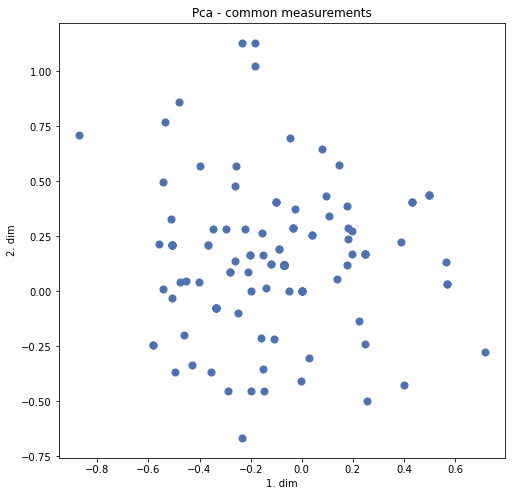

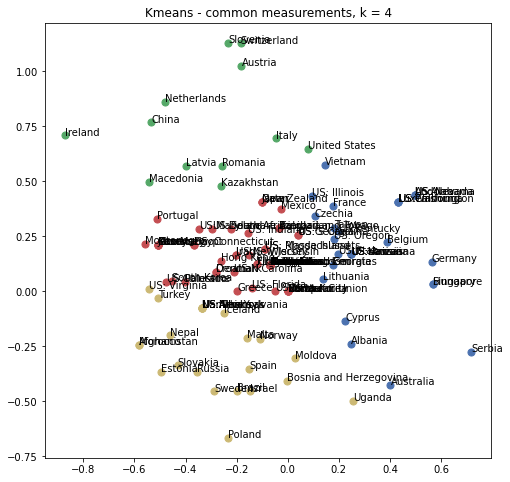

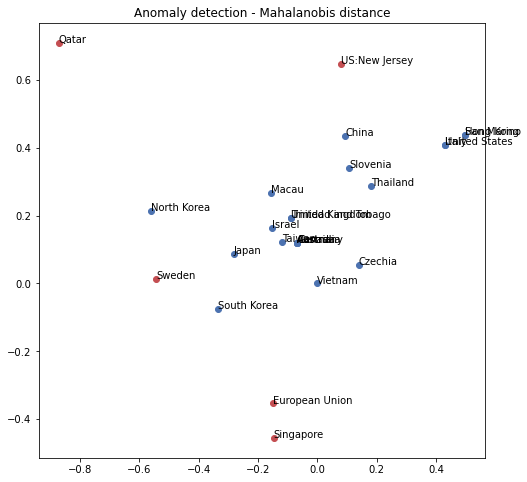

In [30]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 15 12:04:28 2020

@author: bonskotti
"""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KNeighborsClassifier
import statistics as st

def pca(data, no_components):
    """
    Implementation of Principal component analysis.

    Parameters
    ----------
    data : dataframe
        values.
    no_components : int
        how many principal components are included into returnable dataframe.

    Returns
    -------
    dataframe
        n principal components for data

    """
    m = len(data)
    n = len(data.columns)
    
    # 1. vector for means
    means = []
    for c in data.columns:
        means.append(st.mean(data[c]))
            
    # 2. substract mean from data    
    e = data-means
    
    # 3. covariance matrix
    c = 1/(n-1)*np.dot(np.transpose(e),e)
    
    # 4. eigenvalues, eigenvectors
    w, v = np.linalg.eig(c)
    
    # 5. sort eigenvalues and eigenvectors in descending order
    w_sorted = np.sort(w)[::-1]
    v_sorted = v[:,np.argsort(w)]
    
    # 6. project data using two first principal components
    data_pca = np.dot(data,v_sorted[:,0:no_components])
    
    # column names for dataframe
    c = ["pca"+str(comp+1) for comp in range(no_components)]
    
    return pd.DataFrame(data_pca,columns=c)


def knn(X_train,X_test,y_train,n_neigh):
    """
    KNN classification based on clusters created.

    Parameters
    ----------
    X_train : dataframe
        training data.
    X_test : dataframe
        testing data.
    y_train : dataframe
        labels for training data.
    labels : list
        cluster labels.
    n_neigh : int
        number of neighbors for k-nearest-neighbor-algorithm.

    Returns
    -------
    y_test, y_pred : numpy.ndarray, numpy.ndarray
        labels of test-part of data, corresponding predicted labels by the function.
        Use for examining the performance and accuracy of the function.

    """
    
    # apply knn-algorithm
    classifier = KNeighborsClassifier(n_neighbors=n_neigh)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    return y_test, y_pred
    

def anomalies(X_train, X_test, y_train):
    """
    Detecting possible anomalies among coutries based on measurements taken.

    Parameters
    ----------
    data : dataframe
        .

    Returns
    -------
    None.

    """
    
    # calculating Mahalanobis-distances between points and clusters
    covmx = X_train.cov()
    inv = np.linalg.inv(covmx)    
    mahal = DistanceMetric.get_metric('mahalanobis',V=inv)
    d1 = mahal.pairwise(X_test,X_train.loc[y_train==0])
    d2 = mahal.pairwise(X_test,X_train.loc[y_train==1])
    d3 = mahal.pairwise(X_test,X_train.loc[y_train==2])
    #d4 = mahal.pairwise(X_test,X_train.loc[y_train==3])
    
    # calculating maximum distances inside of clusters  
    m1 = max(sum(abs(mahal.pairwise(X_train.loc[y_train==0], X_train.loc[y_train==0]))))
    m2 = max(sum(abs(mahal.pairwise(X_train.loc[y_train==1], X_train.loc[y_train==1]))))
    m3 = max(sum(abs(mahal.pairwise(X_train.loc[y_train==2], X_train.loc[y_train==2]))))
    #m4 = max(sum(abs(mahal.pairwise(X_train.loc[y_train==3], X_train.loc[y_train==3]))))

    # going through distances between points and clusters.
    # if the distance is greater than any of the ones inside of clusters, the point is not 
    # a part of the cluster and it is classified as an anomaly.    
    is_anom = []
    for i in range(len(X_test)):
        if (sum(abs(d1[i])) > m1) & (sum(abs(d2[i])) > m2) & (sum(abs(d3[i])) > m3):
            #& (sum(abs(d4[i])) > m4):
            is_anom.append(1)
        else:
            is_anom.append(0)
            
    return is_anom

    
# import data
cases = pd.read_csv('../data/time_series_covid19_confirmed_global.csv')
measurements = pd.read_csv('../data/COVID 19 Containment measures data.csv')
measurements.dropna(axis=0,how='any',subset=['Country','Keywords'],inplace=True)

# most common measures
common = list(measurements['Keywords'].value_counts()[:10].index.values)

# seperate countries
m_country_specific = {country:measurements[measurements['Country']==country] for country in\
                    measurements['Country'].unique()}
c_country_specific = {country:cases[cases['Country/Region']==country] for country in\
                    cases['Country/Region'].unique()}

# go through every country for most common measures, and mark down whether 
# the measure was taken or not
contains = {country: [c_i in measurements['Keywords'].values for c_i in common]\
            for country, measurements in m_country_specific.items()}

# combine data together
df = pd.DataFrame(data=contains,index=common).T

# principal components
df_pca = pca(df,2)
# concat with labels
labels = pd.DataFrame(list(contains.keys()),columns=['Country'])
df_combined = pd.concat([df_pca,labels],axis=1)

#visualize
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('1. dim')
ax.set_ylabel('2. dim')
ax.set_title('Pca - common measurements')
targets = list(contains.keys())
colors = ['r','b','g','y','c']
for t in targets:
    indeces = df_combined['Country'] == t
    ax.scatter(df_combined.loc[indeces,'pca1']
               ,df_combined.loc[indeces,'pca2']
               ,c='b'
               ,s=50)

# clustering
k = 4
belongs = KMeans(n_clusters=k).fit(np.array(df_pca))

# visualize
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('Kmeans - common measurements, k = '+str(k))
for i,t in enumerate(targets):
    indeces = df_combined['Country'] == t
    ax.scatter(df_combined.loc[indeces,'pca1']
               ,df_combined.loc[indeces,'pca2']
               ,c=colors[belongs.labels_[i]]
               ,s=50)
for i, t in enumerate(targets):
    ax.annotate(t,(df_combined.loc[i,'pca1'],df_combined.loc[i,'pca2']))

# train/test split
X_train, X_test, y_train, y_test = train_test_split(df_pca,belongs.labels_,test_size=0.2)

# knn- classification based on the k klusters created with kmeans
y_test, y_pred = knn(X_train,X_test,y_train,3)        

# evaluating performance
print("=== Classification on test data, based on labels from clustering, KNN ===\n")
print("Confusion matrix\n\n",confusion_matrix(y_test,y_pred))
print()
print("Classification report\n\n",classification_report(y_test,y_pred))
print("Accuracy, knn:",metrics.accuracy_score(y_test,y_pred))

# we can inspect the results with different k's and n's
# with 4 clusters and 3 neighbors, method seems to work well

# anomaly detection
is_anomali = anomalies(X_train,X_test,y_train)

# visualize results
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('Anomaly detection - Mahalanobis distance')
i = 0
indeces_anomaly = [i==1 for i in is_anomali]
indeces_other = [i==0 for i in is_anomali]
i = 0
ax.scatter(X_test.loc[indeces_anomaly,'pca1']
           ,X_test.loc[indeces_anomaly,'pca2']
           ,c='r')
ax.scatter(X_test.loc[indeces_other,'pca1']
           ,X_test.loc[indeces_other,'pca2']
           ,c='b')
for i, t in enumerate(X_test.index):
    # country names from original dataframe using indeces
    ax.annotate(df_combined.iloc[i]['Country'],\
                (X_test.loc[t,'pca1'], X_test.loc[t,'pca2']))

## 5. Evaluation

1. Frequent items mostly related to the growth levels.
2. Classification of a country into a cluster based on measurements taken works fairly well. In addition, it is possible to detect if a country's COVID-19 policies differ from others'.

## 6. Next steps

- Combine the four countries data, and find association rules again.
- Spelling on some of the measurements differ between countries, process the data more to improve performance.